In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import math

# for k fold cross validation accuracy
from sklearn.model_selection import StratifiedKFold

In [2]:
# load in data and labels    
data = np.array(np.loadtxt('data.txt')) # (5000L, 784L) -> note that 784 = 28*28
labels = np.loadtxt('labels.txt') 
dy, dx = data.shape

def most_common(lst):
    return max(set(lst), key=lst.count)

def visualize_trained_map_with_label(clusters, size_k):
    array = np.empty((size_k, size_k))
    
    for i in range(len(clusters)):
        if len(clusters[i]) > 0:
            array[int(i/size_k)][int(i%size_k)] = int(most_common(clusters[i]))
        else:
            array[int(i/size_k)][int(i%size_k)] = -1
    
    ax = sns.heatmap(array, annot=True)

def kohonen_test_supervised(targetdigits = [2, 4, 6, 8], _sigma = 2, _size_k = 6, _eta = 0.9, _tmax = 5000):
    dim = 28*28
    data_range = 255.0
    
    data_and_labels = np.concatenate((data, labels[:, None]), axis = 1)
    
    temp_data = data_and_labels[np.logical_or.reduce([labels==x for x in [targetdigits[0]] ]),:]
    train, test = temp_data[0 : int(0.7 * len(temp_data))], temp_data[int(0.7 * len(temp_data)) : len(temp_data)]
    
    for i in range(1, len(targetdigits)):
        temp_data = data_and_labels[np.logical_or.reduce([labels==x for x in [targetdigits[i]] ]),:]
        train = np.concatenate((train, temp_data[0 : int(0.7 * len(temp_data))]))
        test = np.concatenate((test, temp_data[int(0.7 * len(temp_data)) : len(temp_data)]))
    
    # split into training and testing set
    x_train, y_train = train[:, 0 : len(train[0]) - 1], train[:, -1]
    x_test, y_test = test[:, 0 : len(test[0]) - 1], test[:, -1]
    
    size_k, sigma, eta, tmax = _size_k, _sigma, _eta, _tmax
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % len(train)
    np.random.shuffle(i_random)
    
    for t, i in enumerate(i_random):
        som_step(centers, x_train[i,:],neighbor,eta,sigma)
        
    # for visualization, you can use this:
    for i in range(1, size_k**2+1):
        plb.subplot(size_k,size_k,i)
        
        plb.imshow(np.reshape(centers[i-1,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')
        
    # leave the window open at the end of the loop
    plb.show()
    plb.draw()
    
    kohonen_predict(centers, size_k, x_train, y_train, x_test, y_test)
    
    

def kohonen_learning_curve(targetdigits = [2, 4, 6, 8], _sigma = 2, _size_k = 6, _eta = 0.9, epoch = 10, sigma_decay=False):
    # train kohonen map and compute testing accuracy
    dim = 28*28
    data_range = 255.0
    
    size_k, sigma, eta = _size_k, _sigma, _eta
    
    data_and_labels = np.concatenate((data, labels[:, None]), axis = 1)
    
    temp_data = data_and_labels[np.logical_or.reduce([labels==x for x in [targetdigits[0]] ]),:]
    train, test = temp_data[0 : int(0.7 * len(temp_data))], temp_data[int(0.7 * len(temp_data)) : len(temp_data)]
    
    for i in range(1, len(targetdigits)):
        temp_data = data_and_labels[np.logical_or.reduce([labels==x for x in [targetdigits[i]] ]),:]
        train = np.concatenate((train, temp_data[0 : int(0.7 * len(temp_data))]))
        test = np.concatenate((test, temp_data[int(0.7 * len(temp_data)) : len(temp_data)]))
    
    # split into training and testing set
    x_train, y_train = train[:, 0 : len(train[0]) - 1], train[:, -1]
    x_test, y_test = test[:, 0 : len(test[0]) - 1], test[:, -1]
    
    #initialise the centers randomly, build neighborhood matrix
    centers = np.random.rand(size_k**2, dim) * data_range
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))
    
    ls_accuracy = []
    
    for i in range(epoch):
        # 1. train     
        i_random = np.arange(len(x_train))
        np.random.shuffle(i_random)
        
        for j in range(len(i_random)):
            index = i_random[j]
            sig = sigma
            
            if sigma_decay:
                # exponential decay of sigma
                sig = sigma * math.exp(-0.1*i)
            
            som_step(centers, x_train[index,:],neighbor,eta,sig)
        
        # 2. Get train and test accuracy
        train_accuracy, test_accuracy = kohonen_predict(centers, size_k, x_train, y_train, x_test, y_test, visualize=False)
        
        print('Train accuracy: ' + str(train_accuracy), 'Test accuracy: ' + str(test_accuracy))
        
        iterations = len(x_train)*(i+1)
        ls_accuracy.append([iterations, train_accuracy, test_accuracy])
        
    ls_accuracy = np.array(ls_accuracy)
    
    plt.plot(ls_accuracy[:, 0], ls_accuracy[:, 1])
    plt.plot(ls_accuracy[:, 0], ls_accuracy[:, 2])
    
    plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
    plt.show()
    
    # for visualization, you can use this:
    for i in range(1, size_k**2+1):
        plb.subplot(size_k,size_k,i)
        
        plb.imshow(np.reshape(centers[i-1,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')
        
    # leave the window open at the end of the loop
    plb.show()
    plb.draw()
    
    kohonen_predict(centers, size_k, x_train, y_train, x_test, y_test, visualize=True)
    
    
def kohonen_predict(centers, size_k, x_train, y_train, x_test, y_test, visualize = True):
    # identify 'clusters', treat each winning neuron (based on training dataset) as a cluster itself
    clusters = [[] for i in range(size_k**2)]
    winning_clusters = {}
    
    for i in range(len(x_train)):
        # find winning neuron
        win_location = np.argmin(np.sum((centers - np.resize(x_train[i], (size_k**2, x_train[i].size)))**2,1))
        clusters[win_location].append(int(y_train[i]))
        
    for i in range(len(clusters)):
        if len(clusters[i]) > 0: 
            winning_clusters[i] = most_common(clusters[i])
            
    # visualize trained map with each neuron assigned a label
    if visualize:
        visualize_trained_map_with_label(clusters, size_k)
            
    # Calculate accuracy
    train_accuracy = 0
    test_accuracy = 0
    
    for i in range(len(x_train)):
        min_loc = winning_clusters.keys()[0]
        
        for j in winning_clusters.keys():
            if np.linalg.norm(x_train[i] - centers[j]) < np.linalg.norm(x_train[i] - centers[min_loc]):
                min_loc = j
                
        if int(winning_clusters[min_loc]) == int(y_train[i]):
            train_accuracy += 1
    
    if visualize:
        print("Number of correct predictions for training set: " + str(train_accuracy))
        print("Training accuracy: " + str(float(train_accuracy)/len(x_train)))
        print("---------------------------------------")
    
    for i in range(len(x_test)):
        min_loc = winning_clusters.keys()[0]
        
        for j in winning_clusters.keys():
            if np.linalg.norm(x_test[i] - centers[j]) < np.linalg.norm(x_test[i] - centers[min_loc]):
                min_loc = j
                
        if int(winning_clusters[min_loc]) == int(y_test[i]):
            test_accuracy += 1
    
    if visualize:
        print("Number of correct predictions for testing set: " + str(test_accuracy))
        print("Test accuracy: " + str(float(test_accuracy)/len(x_test)))
        print("---------------------------------------")
    
    train_accuracy = float(train_accuracy)/len(x_train)
    test_accuracy = float(test_accuracy)/len(x_test)
    return train_accuracy, test_accuracy
    
    
    
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])
        

def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

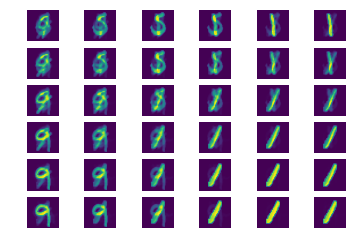

Number of correct predictions for training set: 1041
Training accuracy: 0.671612903226
---------------------------------------
Number of correct predictions for testing set: 213
Test accuracy: 0.473333333333
---------------------------------------


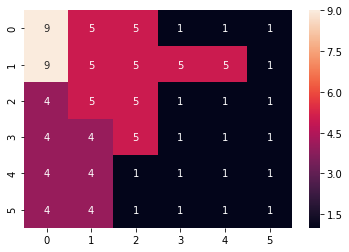

In [4]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 2,
    'size_k': 6,
    'eta': 0.9,
    'tmax': 5000
}

kohonen_test_supervised(targetdigits = config['targetdigits'], 
                        _sigma = config['sigma'], 
                        _size_k = config['size_k'], 
                        _eta = config['eta'], 
                        _tmax = config['tmax'])

### 1. Start with a Kohonen network of 6x6 neurons that are arranged on a square grid with unit distance and use a Gaussian neighborhood function with (constant) standard deviation $\sigma = 3$ Implement the Kohonen algorithm and apply it to the data in data.txt. Choose a small (constant) learning rate and report how you decide when your algorithm has converged.

To qualitatively measure the performance of a Kohonen map, we tried to use the trained Kohonen map as a classifier to classify unknown input vectors. 

At the end of each epoch of the training procedure, we calculate both training and testing accuracy using the latest Kohonen map and plot the learning curve of the Kohonen map.  

('Train accuracy: 0.251428571429', 'Test accuracy: 0.251666666667')
('Train accuracy: 0.336428571429', 'Test accuracy: 0.356666666667')
('Train accuracy: 0.581428571429', 'Test accuracy: 0.586666666667')
('Train accuracy: 0.668571428571', 'Test accuracy: 0.628333333333')
('Train accuracy: 0.700714285714', 'Test accuracy: 0.641666666667')
('Train accuracy: 0.716428571429', 'Test accuracy: 0.678333333333')
('Train accuracy: 0.741428571429', 'Test accuracy: 0.685')
('Train accuracy: 0.74', 'Test accuracy: 0.69')
('Train accuracy: 0.738571428571', 'Test accuracy: 0.68')
('Train accuracy: 0.754285714286', 'Test accuracy: 0.681666666667')
('Train accuracy: 0.755', 'Test accuracy: 0.691666666667')
('Train accuracy: 0.761428571429', 'Test accuracy: 0.708333333333')
('Train accuracy: 0.747142857143', 'Test accuracy: 0.705')
('Train accuracy: 0.742857142857', 'Test accuracy: 0.685')
('Train accuracy: 0.734285714286', 'Test accuracy: 0.675')
('Train accuracy: 0.746428571429', 'Test accuracy: 0.70

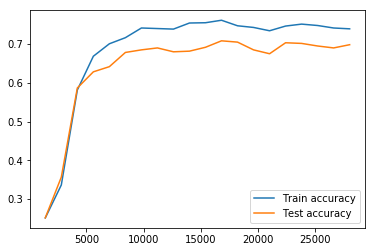

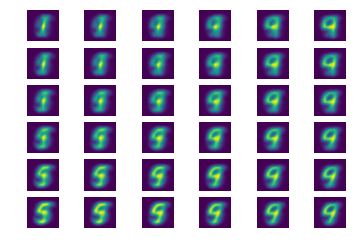

Number of correct predictions for training set: 1035
Training accuracy: 0.739285714286
---------------------------------------
Number of correct predictions for testing set: 419
Test accuracy: 0.698333333333
---------------------------------------


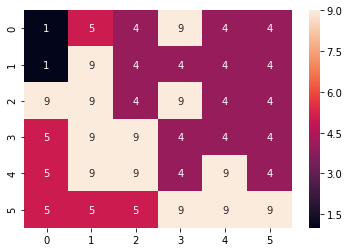

In [78]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 6,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

### 2. Using the information in (labels.txt), find a way to automatically assign one digit to each prototype that is represented best by it. Visualize and interpret your results.

### 3. Explore different sizes of the Kohonen map (try at least 3 different sizes, not less than 36 units). Explore different widths of the neighborhood function (try at least $\sigma = 1, 3, 5$). Describe the role of the width of the neighborhood function. Does the optimal width depend on the size of the Kohonen map?

#### Vary size_k

('Train accuracy: 0.265714285714', 'Test accuracy: 0.261666666667')
('Train accuracy: 0.352857142857', 'Test accuracy: 0.316666666667')
('Train accuracy: 0.594285714286', 'Test accuracy: 0.56')
('Train accuracy: 0.696428571429', 'Test accuracy: 0.658333333333')
('Train accuracy: 0.727857142857', 'Test accuracy: 0.69')
('Train accuracy: 0.748571428571', 'Test accuracy: 0.705')
('Train accuracy: 0.746428571429', 'Test accuracy: 0.695')
('Train accuracy: 0.752142857143', 'Test accuracy: 0.72')
('Train accuracy: 0.753571428571', 'Test accuracy: 0.691666666667')
('Train accuracy: 0.766428571429', 'Test accuracy: 0.716666666667')
('Train accuracy: 0.776428571429', 'Test accuracy: 0.728333333333')
('Train accuracy: 0.780714285714', 'Test accuracy: 0.715')
('Train accuracy: 0.780714285714', 'Test accuracy: 0.721666666667')
('Train accuracy: 0.777142857143', 'Test accuracy: 0.715')
('Train accuracy: 0.777142857143', 'Test accuracy: 0.691666666667')
('Train accuracy: 0.785', 'Test accuracy: 0.7'

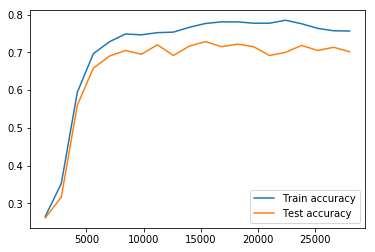

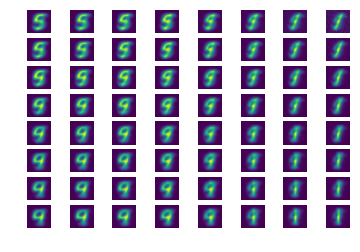

Number of correct predictions for training set: 1059
Training accuracy: 0.756428571429
---------------------------------------
Number of correct predictions for testing set: 421
Test accuracy: 0.701666666667
---------------------------------------


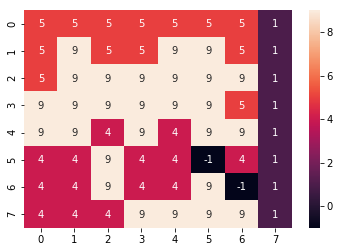

In [81]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

('Train accuracy: 0.265714285714', 'Test accuracy: 0.261666666667')
('Train accuracy: 0.389285714286', 'Test accuracy: 0.39')
('Train accuracy: 0.636428571429', 'Test accuracy: 0.645')
('Train accuracy: 0.722142857143', 'Test accuracy: 0.675')
('Train accuracy: 0.722857142857', 'Test accuracy: 0.66')
('Train accuracy: 0.727142857143', 'Test accuracy: 0.688333333333')
('Train accuracy: 0.734285714286', 'Test accuracy: 0.691666666667')
('Train accuracy: 0.730714285714', 'Test accuracy: 0.678333333333')
('Train accuracy: 0.730714285714', 'Test accuracy: 0.693333333333')
('Train accuracy: 0.738571428571', 'Test accuracy: 0.721666666667')
('Train accuracy: 0.742142857143', 'Test accuracy: 0.706666666667')
('Train accuracy: 0.741428571429', 'Test accuracy: 0.686666666667')
('Train accuracy: 0.749285714286', 'Test accuracy: 0.701666666667')
('Train accuracy: 0.751428571429', 'Test accuracy: 0.701666666667')
('Train accuracy: 0.738571428571', 'Test accuracy: 0.706666666667')
('Train accuracy: 

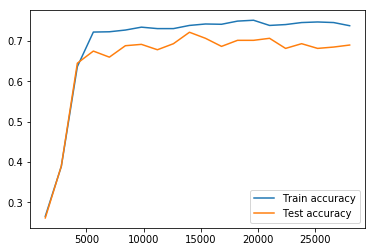

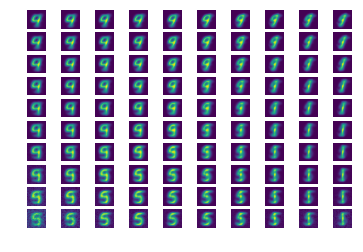

Number of correct predictions for training set: 1033
Training accuracy: 0.737857142857
---------------------------------------
Number of correct predictions for testing set: 414
Test accuracy: 0.69
---------------------------------------


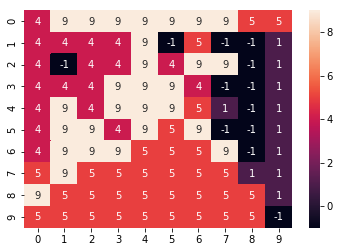

In [83]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 10,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

('Train accuracy: 0.31', 'Test accuracy: 0.303333333333')
('Train accuracy: 0.415714285714', 'Test accuracy: 0.388333333333')
('Train accuracy: 0.632142857143', 'Test accuracy: 0.578333333333')
('Train accuracy: 0.722142857143', 'Test accuracy: 0.705')
('Train accuracy: 0.763571428571', 'Test accuracy: 0.713333333333')
('Train accuracy: 0.757857142857', 'Test accuracy: 0.746666666667')
('Train accuracy: 0.76', 'Test accuracy: 0.731666666667')
('Train accuracy: 0.768571428571', 'Test accuracy: 0.725')
('Train accuracy: 0.774285714286', 'Test accuracy: 0.741666666667')
('Train accuracy: 0.77', 'Test accuracy: 0.745')
('Train accuracy: 0.767142857143', 'Test accuracy: 0.763333333333')
('Train accuracy: 0.767142857143', 'Test accuracy: 0.735')
('Train accuracy: 0.762142857143', 'Test accuracy: 0.728333333333')
('Train accuracy: 0.764285714286', 'Test accuracy: 0.723333333333')
('Train accuracy: 0.766428571429', 'Test accuracy: 0.713333333333')
('Train accuracy: 0.767857142857', 'Test accur

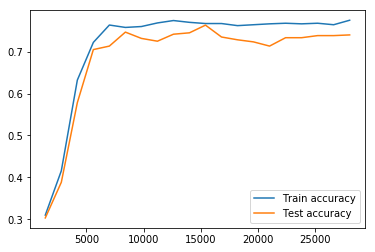

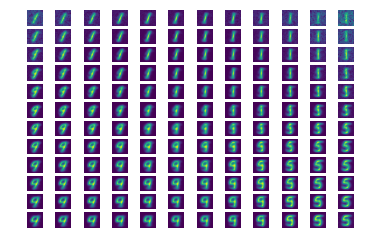

Number of correct predictions for training set: 1085
Training accuracy: 0.775
---------------------------------------
Number of correct predictions for testing set: 444
Test accuracy: 0.74
---------------------------------------


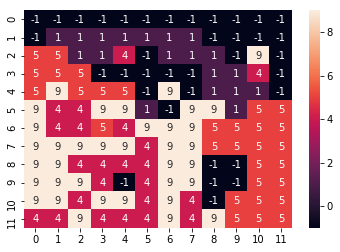

In [84]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 12,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

('Train accuracy: 0.265', 'Test accuracy: 0.27')
('Train accuracy: 0.396428571429', 'Test accuracy: 0.398333333333')
('Train accuracy: 0.639285714286', 'Test accuracy: 0.58')
('Train accuracy: 0.713571428571', 'Test accuracy: 0.663333333333')
('Train accuracy: 0.721428571429', 'Test accuracy: 0.658333333333')
('Train accuracy: 0.742142857143', 'Test accuracy: 0.696666666667')
('Train accuracy: 0.74', 'Test accuracy: 0.693333333333')
('Train accuracy: 0.753571428571', 'Test accuracy: 0.691666666667')
('Train accuracy: 0.752142857143', 'Test accuracy: 0.703333333333')
('Train accuracy: 0.746428571429', 'Test accuracy: 0.681666666667')
('Train accuracy: 0.748571428571', 'Test accuracy: 0.701666666667')
('Train accuracy: 0.742857142857', 'Test accuracy: 0.718333333333')
('Train accuracy: 0.742857142857', 'Test accuracy: 0.713333333333')
('Train accuracy: 0.742142857143', 'Test accuracy: 0.71')
('Train accuracy: 0.748571428571', 'Test accuracy: 0.718333333333')
('Train accuracy: 0.754285714

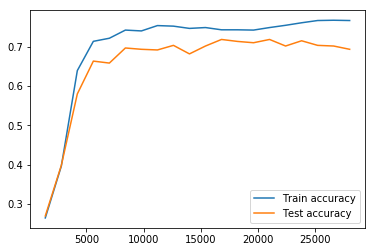

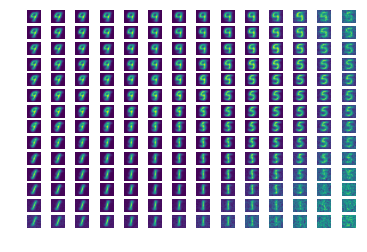

Number of correct predictions for training set: 1073
Training accuracy: 0.766428571429
---------------------------------------
Number of correct predictions for testing set: 416
Test accuracy: 0.693333333333
---------------------------------------


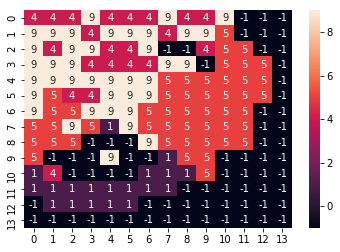

In [85]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 14,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

#### Vary sigma

('Train accuracy: 0.25', 'Test accuracy: 0.25')
('Train accuracy: 0.251428571429', 'Test accuracy: 0.251666666667')
('Train accuracy: 0.295714285714', 'Test accuracy: 0.3')
('Train accuracy: 0.410714285714', 'Test accuracy: 0.398333333333')
('Train accuracy: 0.492857142857', 'Test accuracy: 0.458333333333')
('Train accuracy: 0.637857142857', 'Test accuracy: 0.596666666667')
('Train accuracy: 0.681428571429', 'Test accuracy: 0.621666666667')
('Train accuracy: 0.717857142857', 'Test accuracy: 0.713333333333')
('Train accuracy: 0.717142857143', 'Test accuracy: 0.686666666667')
('Train accuracy: 0.714285714286', 'Test accuracy: 0.666666666667')
('Train accuracy: 0.72', 'Test accuracy: 0.67')
('Train accuracy: 0.728571428571', 'Test accuracy: 0.685')
('Train accuracy: 0.730714285714', 'Test accuracy: 0.69')
('Train accuracy: 0.728571428571', 'Test accuracy: 0.691666666667')
('Train accuracy: 0.730714285714', 'Test accuracy: 0.696666666667')
('Train accuracy: 0.737142857143', 'Test accuracy:

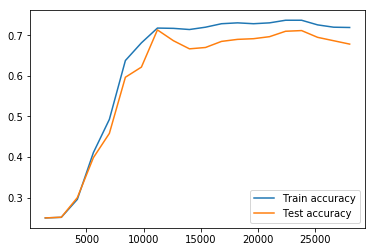

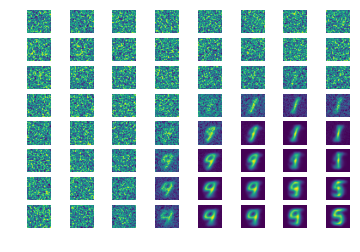

Number of correct predictions for training set: 1007
Training accuracy: 0.719285714286
---------------------------------------
Number of correct predictions for testing set: 407
Test accuracy: 0.678333333333
---------------------------------------


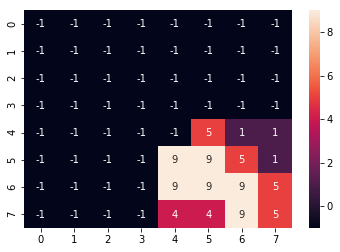

In [92]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 1,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

('Train accuracy: 0.253571428571', 'Test accuracy: 0.25')
('Train accuracy: 0.309285714286', 'Test accuracy: 0.291666666667')
('Train accuracy: 0.446428571429', 'Test accuracy: 0.435')
('Train accuracy: 0.592142857143', 'Test accuracy: 0.541666666667')
('Train accuracy: 0.647142857143', 'Test accuracy: 0.59')
('Train accuracy: 0.670714285714', 'Test accuracy: 0.638333333333')
('Train accuracy: 0.702142857143', 'Test accuracy: 0.656666666667')
('Train accuracy: 0.707857142857', 'Test accuracy: 0.671666666667')
('Train accuracy: 0.711428571429', 'Test accuracy: 0.668333333333')
('Train accuracy: 0.717142857143', 'Test accuracy: 0.676666666667')
('Train accuracy: 0.723571428571', 'Test accuracy: 0.683333333333')
('Train accuracy: 0.725', 'Test accuracy: 0.685')
('Train accuracy: 0.737857142857', 'Test accuracy: 0.7')
('Train accuracy: 0.745714285714', 'Test accuracy: 0.7')
('Train accuracy: 0.737142857143', 'Test accuracy: 0.706666666667')
('Train accuracy: 0.746428571429', 'Test accuracy

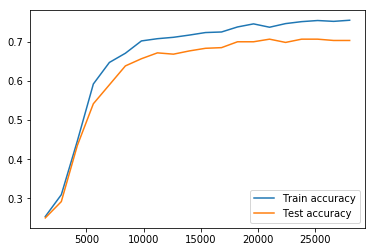

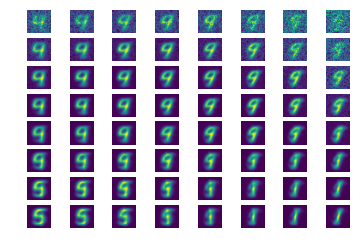

Number of correct predictions for training set: 1057
Training accuracy: 0.755
---------------------------------------
Number of correct predictions for testing set: 422
Test accuracy: 0.703333333333
---------------------------------------


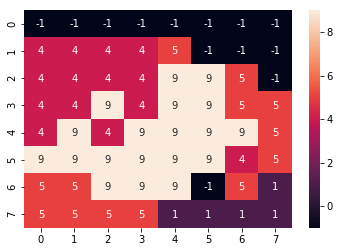

In [93]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 2,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

('Train accuracy: 0.310714285714', 'Test accuracy: 0.311666666667')
('Train accuracy: 0.433571428571', 'Test accuracy: 0.413333333333')
('Train accuracy: 0.646428571429', 'Test accuracy: 0.598333333333')
('Train accuracy: 0.707857142857', 'Test accuracy: 0.673333333333')
('Train accuracy: 0.72', 'Test accuracy: 0.661666666667')
('Train accuracy: 0.727857142857', 'Test accuracy: 0.68')
('Train accuracy: 0.730714285714', 'Test accuracy: 0.668333333333')
('Train accuracy: 0.735714285714', 'Test accuracy: 0.693333333333')
('Train accuracy: 0.747142857143', 'Test accuracy: 0.673333333333')
('Train accuracy: 0.743571428571', 'Test accuracy: 0.668333333333')
('Train accuracy: 0.745714285714', 'Test accuracy: 0.676666666667')
('Train accuracy: 0.75', 'Test accuracy: 0.691666666667')
('Train accuracy: 0.746428571429', 'Test accuracy: 0.675')
('Train accuracy: 0.744285714286', 'Test accuracy: 0.673333333333')
('Train accuracy: 0.742142857143', 'Test accuracy: 0.683333333333')
('Train accuracy: 0

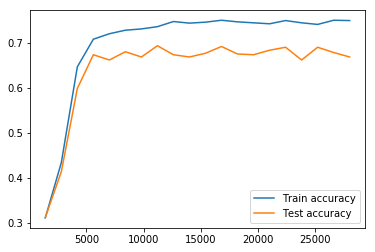

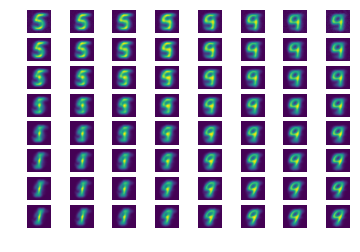

Number of correct predictions for training set: 1049
Training accuracy: 0.749285714286
---------------------------------------
Number of correct predictions for testing set: 401
Test accuracy: 0.668333333333
---------------------------------------


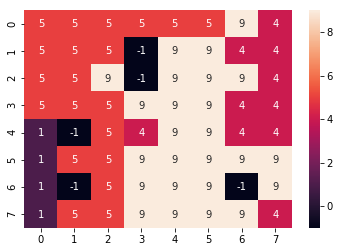

In [94]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

('Train accuracy: 0.397857142857', 'Test accuracy: 0.386666666667')
('Train accuracy: 0.524285714286', 'Test accuracy: 0.538333333333')
('Train accuracy: 0.640714285714', 'Test accuracy: 0.635')
('Train accuracy: 0.695714285714', 'Test accuracy: 0.643333333333')
('Train accuracy: 0.707857142857', 'Test accuracy: 0.643333333333')
('Train accuracy: 0.717857142857', 'Test accuracy: 0.653333333333')
('Train accuracy: 0.725', 'Test accuracy: 0.641666666667')
('Train accuracy: 0.725714285714', 'Test accuracy: 0.665')
('Train accuracy: 0.727142857143', 'Test accuracy: 0.68')
('Train accuracy: 0.726428571429', 'Test accuracy: 0.666666666667')
('Train accuracy: 0.73', 'Test accuracy: 0.665')
('Train accuracy: 0.735714285714', 'Test accuracy: 0.681666666667')
('Train accuracy: 0.737857142857', 'Test accuracy: 0.671666666667')
('Train accuracy: 0.736428571429', 'Test accuracy: 0.673333333333')
('Train accuracy: 0.736428571429', 'Test accuracy: 0.678333333333')
('Train accuracy: 0.735714285714', '

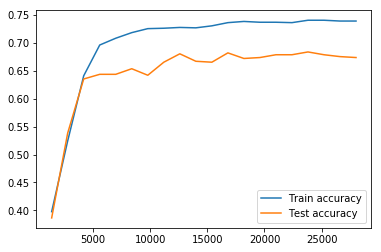

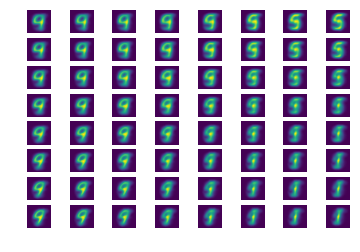

Number of correct predictions for training set: 1034
Training accuracy: 0.738571428571
---------------------------------------
Number of correct predictions for testing set: 404
Test accuracy: 0.673333333333
---------------------------------------


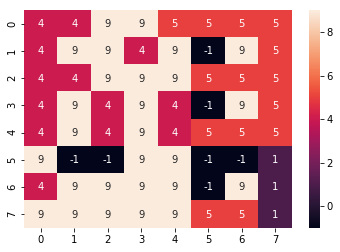

In [95]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 4,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

('Train accuracy: 0.402142857143', 'Test accuracy: 0.383333333333')
('Train accuracy: 0.549285714286', 'Test accuracy: 0.511666666667')
('Train accuracy: 0.697857142857', 'Test accuracy: 0.671666666667')
('Train accuracy: 0.706428571429', 'Test accuracy: 0.641666666667')
('Train accuracy: 0.691428571429', 'Test accuracy: 0.64')
('Train accuracy: 0.681428571429', 'Test accuracy: 0.628333333333')
('Train accuracy: 0.676428571429', 'Test accuracy: 0.625')
('Train accuracy: 0.687857142857', 'Test accuracy: 0.643333333333')
('Train accuracy: 0.703571428571', 'Test accuracy: 0.636666666667')
('Train accuracy: 0.714285714286', 'Test accuracy: 0.641666666667')
('Train accuracy: 0.712142857143', 'Test accuracy: 0.633333333333')
('Train accuracy: 0.718571428571', 'Test accuracy: 0.663333333333')
('Train accuracy: 0.721428571429', 'Test accuracy: 0.65')
('Train accuracy: 0.727857142857', 'Test accuracy: 0.683333333333')
('Train accuracy: 0.727857142857', 'Test accuracy: 0.655')
('Train accuracy: 

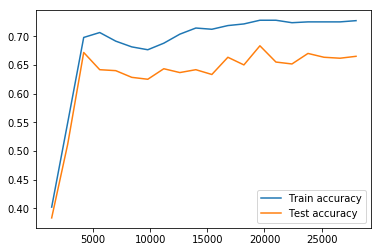

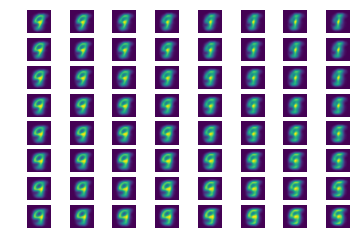

Number of correct predictions for training set: 1018
Training accuracy: 0.727142857143
---------------------------------------
Number of correct predictions for testing set: 399
Test accuracy: 0.665
---------------------------------------


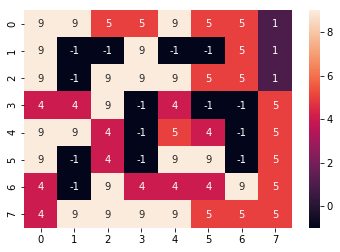

In [96]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 5,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

### 4. Until now, the width of the neighborhood function has been constant. Now, start with a large $\sigma$ and decrease it over the runtime of the algorithm. Does it improve your result?

('Train accuracy: 0.263571428571', 'Test accuracy: 0.255')
('Train accuracy: 0.345', 'Test accuracy: 0.338333333333')
('Train accuracy: 0.53', 'Test accuracy: 0.535')
('Train accuracy: 0.602857142857', 'Test accuracy: 0.543333333333')
('Train accuracy: 0.637142857143', 'Test accuracy: 0.586666666667')
('Train accuracy: 0.677857142857', 'Test accuracy: 0.61')
('Train accuracy: 0.7', 'Test accuracy: 0.658333333333')
('Train accuracy: 0.721428571429', 'Test accuracy: 0.653333333333')
('Train accuracy: 0.737142857143', 'Test accuracy: 0.651666666667')
('Train accuracy: 0.746428571429', 'Test accuracy: 0.66')
('Train accuracy: 0.751428571429', 'Test accuracy: 0.675')
('Train accuracy: 0.757142857143', 'Test accuracy: 0.686666666667')
('Train accuracy: 0.765', 'Test accuracy: 0.693333333333')
('Train accuracy: 0.765', 'Test accuracy: 0.696666666667')
('Train accuracy: 0.765', 'Test accuracy: 0.71')
('Train accuracy: 0.768571428571', 'Test accuracy: 0.715')
('Train accuracy: 0.774285714286', 

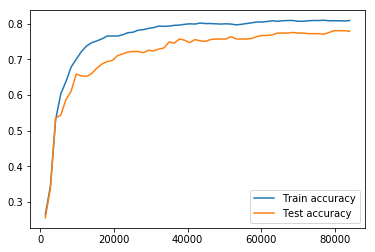

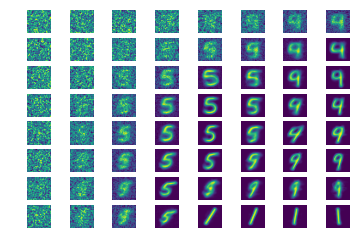

Number of correct predictions for training set: 1132
Training accuracy: 0.808571428571
---------------------------------------
Number of correct predictions for testing set: 467
Test accuracy: 0.778333333333
---------------------------------------


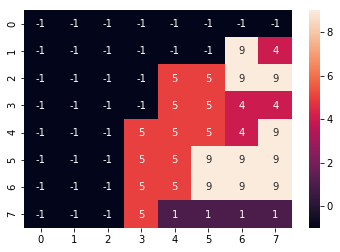

In [109]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 60
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)

('Train accuracy: 0.295', 'Test accuracy: 0.306666666667')
('Train accuracy: 0.378571428571', 'Test accuracy: 0.398333333333')
('Train accuracy: 0.606428571429', 'Test accuracy: 0.59')
('Train accuracy: 0.666428571429', 'Test accuracy: 0.6')
('Train accuracy: 0.702857142857', 'Test accuracy: 0.633333333333')
('Train accuracy: 0.724285714286', 'Test accuracy: 0.651666666667')
('Train accuracy: 0.723571428571', 'Test accuracy: 0.66')
('Train accuracy: 0.734285714286', 'Test accuracy: 0.66')
('Train accuracy: 0.73', 'Test accuracy: 0.7')
('Train accuracy: 0.741428571429', 'Test accuracy: 0.716666666667')
('Train accuracy: 0.742142857143', 'Test accuracy: 0.72')
('Train accuracy: 0.745', 'Test accuracy: 0.708333333333')
('Train accuracy: 0.751428571429', 'Test accuracy: 0.706666666667')
('Train accuracy: 0.756428571429', 'Test accuracy: 0.71')
('Train accuracy: 0.76', 'Test accuracy: 0.715')
('Train accuracy: 0.762142857143', 'Test accuracy: 0.718333333333')
('Train accuracy: 0.76285714285

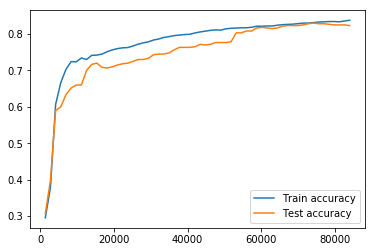

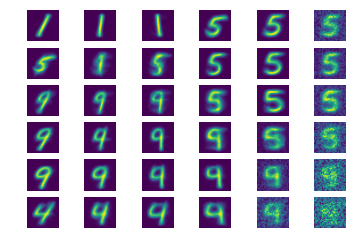

Number of correct predictions for training set: 1173
Training accuracy: 0.837857142857
---------------------------------------
Number of correct predictions for testing set: 494
Test accuracy: 0.823333333333
---------------------------------------


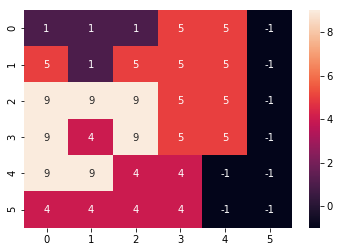

In [110]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 6,
    'eta': 0.0008,
    'epoch': 60
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)

('Train accuracy: 0.292142857143', 'Test accuracy: 0.303333333333')
('Train accuracy: 0.440714285714', 'Test accuracy: 0.45')
('Train accuracy: 0.616428571429', 'Test accuracy: 0.561666666667')
('Train accuracy: 0.695', 'Test accuracy: 0.623333333333')
('Train accuracy: 0.717857142857', 'Test accuracy: 0.653333333333')
('Train accuracy: 0.730714285714', 'Test accuracy: 0.705')
('Train accuracy: 0.729285714286', 'Test accuracy: 0.666666666667')
('Train accuracy: 0.722142857143', 'Test accuracy: 0.661666666667')
('Train accuracy: 0.720714285714', 'Test accuracy: 0.69')
('Train accuracy: 0.728571428571', 'Test accuracy: 0.685')
('Train accuracy: 0.735714285714', 'Test accuracy: 0.69')
('Train accuracy: 0.734285714286', 'Test accuracy: 0.693333333333')
('Train accuracy: 0.74', 'Test accuracy: 0.698333333333')
('Train accuracy: 0.743571428571', 'Test accuracy: 0.701666666667')
('Train accuracy: 0.745', 'Test accuracy: 0.698333333333')
('Train accuracy: 0.75', 'Test accuracy: 0.715')
('Train

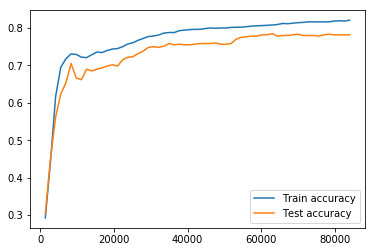

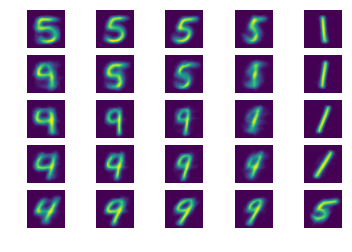

Number of correct predictions for training set: 1149
Training accuracy: 0.820714285714
---------------------------------------
Number of correct predictions for testing set: 469
Test accuracy: 0.781666666667
---------------------------------------


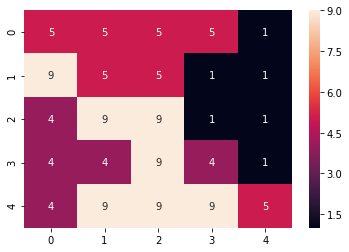

In [111]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 5,
    'eta': 0.0008,
    'epoch': 60
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)

('Train accuracy: 0.261785714286', 'Test accuracy: 0.261666666667')
('Train accuracy: 0.4425', 'Test accuracy: 0.415')
('Train accuracy: 0.487857142857', 'Test accuracy: 0.455')
('Train accuracy: 0.503928571429', 'Test accuracy: 0.4675')
('Train accuracy: 0.518214285714', 'Test accuracy: 0.485833333333')
('Train accuracy: 0.537857142857', 'Test accuracy: 0.501666666667')
('Train accuracy: 0.561071428571', 'Test accuracy: 0.545833333333')
('Train accuracy: 0.595', 'Test accuracy: 0.5775')
('Train accuracy: 0.623214285714', 'Test accuracy: 0.594166666667')
('Train accuracy: 0.639285714286', 'Test accuracy: 0.6175')
('Train accuracy: 0.66', 'Test accuracy: 0.6425')
('Train accuracy: 0.6725', 'Test accuracy: 0.658333333333')
('Train accuracy: 0.681785714286', 'Test accuracy: 0.674166666667')
('Train accuracy: 0.693928571429', 'Test accuracy: 0.681666666667')
('Train accuracy: 0.703928571429', 'Test accuracy: 0.703333333333')
('Train accuracy: 0.714642857143', 'Test accuracy: 0.714166666667

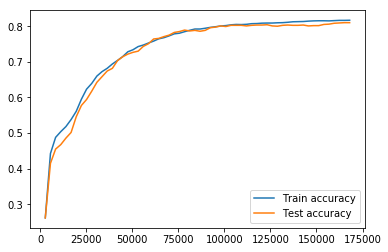

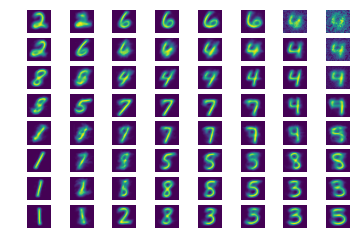

Number of correct predictions for training set: 2287
Training accuracy: 0.816785714286
---------------------------------------
Number of correct predictions for testing set: 972
Test accuracy: 0.81
---------------------------------------


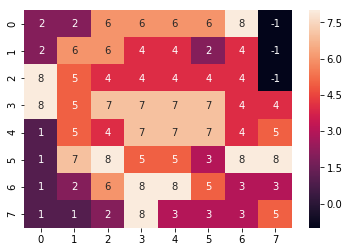

In [112]:
config = {
    'targetdigits': [1, 2, 3, 4, 5, 6, 7, 8],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 60
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)

('Train accuracy: 0.289142857143', 'Test accuracy: 0.292')
('Train accuracy: 0.395714285714', 'Test accuracy: 0.374666666667')
('Train accuracy: 0.414', 'Test accuracy: 0.378666666667')
('Train accuracy: 0.448285714286', 'Test accuracy: 0.424666666667')
('Train accuracy: 0.481142857143', 'Test accuracy: 0.465333333333')
('Train accuracy: 0.499142857143', 'Test accuracy: 0.474666666667')
('Train accuracy: 0.515714285714', 'Test accuracy: 0.472666666667')
('Train accuracy: 0.536571428571', 'Test accuracy: 0.508')
('Train accuracy: 0.552857142857', 'Test accuracy: 0.527333333333')
('Train accuracy: 0.564571428571', 'Test accuracy: 0.532')
('Train accuracy: 0.579714285714', 'Test accuracy: 0.548666666667')
('Train accuracy: 0.590285714286', 'Test accuracy: 0.559333333333')
('Train accuracy: 0.601428571429', 'Test accuracy: 0.568666666667')
('Train accuracy: 0.614285714286', 'Test accuracy: 0.588')
('Train accuracy: 0.621714285714', 'Test accuracy: 0.594666666667')
('Train accuracy: 0.63085

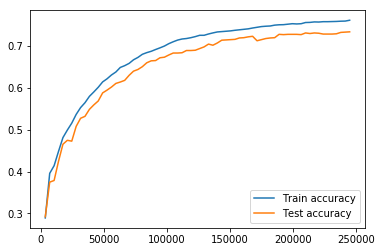

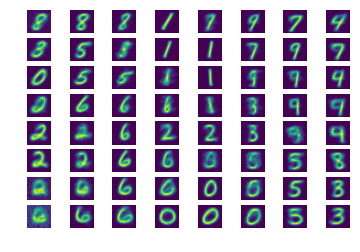

Number of correct predictions for training set: 2666
Training accuracy: 0.761714285714
---------------------------------------
Number of correct predictions for testing set: 1101
Test accuracy: 0.734
---------------------------------------


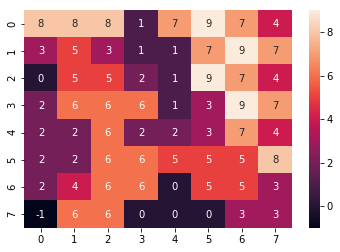

In [3]:
config = {
    'targetdigits': [1, 2, 3, 4, 5, 6, 7, 8, 9, 0],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 70
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)